In [21]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt

import tensorflow_datasets as tfds

In [22]:
# Tensorflow가 활용할 GPU가 장착되어 있는지 확인해 봅니다.
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [23]:
import urllib3
urllib3.disable_warnings()

#tfds.disable_progress_bar()   # 이 주석을 풀면 데이터셋 다운로드과정의 프로그레스바가 나타나지 않습니다.

(ds_train, ds_test), ds_info = tfds.load(
    'cifar10',
    split=['train', 'test'],
    shuffle_files=True,
    with_info=True,
)

In [24]:
# Tensorflow 데이터셋을 로드하면 꼭 feature 정보를 확인해 보세요. 
print(ds_info.features)

FeaturesDict({
    'id': Text(shape=(), dtype=tf.string),
    'image': Image(shape=(32, 32, 3), dtype=tf.uint8),
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=10),
})


In [25]:
# 데이터의 개수도 확인해 봅시다. 
print(tf.data.experimental.cardinality(ds_train))
print(tf.data.experimental.cardinality(ds_test))

tf.Tensor(50000, shape=(), dtype=int64)
tf.Tensor(10000, shape=(), dtype=int64)


In [26]:
#우리의 모델에 넣어주기 전에는 각 채널별 최댓값인 255로 정규화(normalize)를 해주어 이미지의 표현이 0과 1 사이로 들어오도록 만들어줍니다.
def normalize_and_resize_img(image, label):
    """Normalizes images: `uint8` -> `float32`."""
    # image = tf.image.resize(image, [32, 32])
    return tf.cast(image, tf.float32) / 255., label

In [27]:
def apply_normalize_on_dataset(ds, is_test=False, batch_size=16):
    ds = ds.map(
        normalize_and_resize_img, 
        num_parallel_calls=1
    )
    ds = ds.batch(batch_size)
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

In [28]:
#MNIST 데이터셋 클래스는 0부터 9까지의 숫자, 총 10가지가 있습니다. CIFAR-10 데이터셋 또한 이름에서 알 수 있듯이 10개 클래스를 가집니다. 아래 코드로 각 클래스가 어떻게 구성되는지, 어떤 이미지가 있는지 확인해 보세요!
ds_info.features["label"].num_classes

10

In [29]:
ds_info.features["label"].names

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

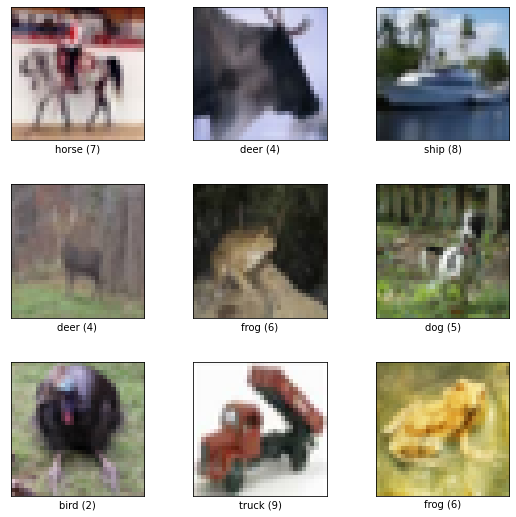

In [30]:
fig = tfds.show_examples(ds_train, ds_info)

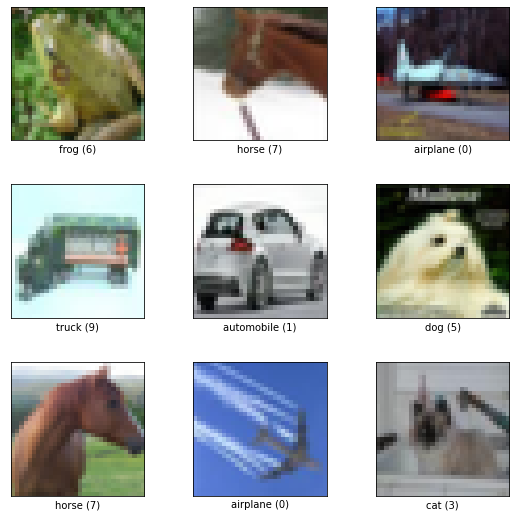

In [31]:
fig = tfds.show_examples(ds_test, ds_info)

In [32]:
# function for building VGG Block

def build_vgg_block(input_layer,
                    num_cnn=3, 
                    channel=64,
                    block_num=1,
                   ):
    # 입력 레이어
    x = input_layer

    # CNN 레이어
    for cnn_num in range(num_cnn):
        x = keras.layers.Conv2D(
            filters=channel,
            kernel_size=(3,3),
            activation='relu',
            kernel_initializer='he_normal',
            padding='same',
            name=f'block{block_num}_conv{cnn_num}'
        )(x)    

    # Max Pooling 레이어
    x = keras.layers.MaxPooling2D(
        pool_size=(2, 2),
        strides=2,
        name=f'block{block_num}_pooling'
    )(x)

    return x

In [33]:
vgg_input_layer = keras.layers.Input(shape=(32,32,3))   # 입력 레이어 생성
vgg_block_output = build_vgg_block(vgg_input_layer)    # VGG 블록 생성

In [34]:
# 블록 1개짜리 model 생성
model = keras.Model(inputs=vgg_input_layer, outputs=vgg_block_output)  

model.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
block1_conv0 (Conv2D)        (None, 32, 32, 64)        1792      
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block1_pooling (MaxPooling2D (None, 16, 16, 64)        0         
Total params: 75,648
Trainable params: 75,648
Non-trainable params: 0
_________________________________________________________________


In [35]:
# VGG 모델 자체를 생성하는 함수입니다.
def build_vgg(input_shape=(32,32,3),
              num_cnn_list=[2,2,3,3,3],
              channel_list=[64,128,256,512,512],
              num_classes=10):
    
    assert len(num_cnn_list) == len(channel_list) #모델을 만들기 전에 config list들이 같은 길이인지 확인합니다.
    
    input_layer = keras.layers.Input(shape=input_shape)  # input layer를 만들어둡니다.
    output = input_layer
    
    # config list들의 길이만큼 반복해서 블록을 생성합니다.
    for i, (num_cnn, channel) in enumerate(zip(num_cnn_list, channel_list)):
        output = build_vgg_block(
            output,
            num_cnn=num_cnn, 
            channel=channel,
            block_num=i
        )
        
    output = keras.layers.Flatten(name='flatten')(output)
    output = keras.layers.Dense(4096, activation='relu', name='fc1')(output)
    output = keras.layers.Dense(4096, activation='relu', name='fc2')(output)
    output = keras.layers.Dense(num_classes, activation='softmax', name='predictions')(output)
    
    model = keras.Model(
        inputs=input_layer, 
        outputs=output
    )
    return model

In [36]:
# VGG 모델 자체를 생성하는 함수입니다.
def build_vgg(input_shape=(32,32,3),
              num_cnn_list=[2,2,3,3,3],
              channel_list=[64,128,256,512,512],
              num_classes=10):
    
    assert len(num_cnn_list) == len(channel_list) #모델을 만들기 전에 config list들이 같은 길이인지 확인합니다. #assert는 뒤의 조건이 True가 아니면 AssertError를 발생한다.
    
    input_layer = keras.layers.Input(shape=input_shape)  # input layer를 만들어둡니다.
    output = input_layer
    
    # config list들의 길이만큼 반복해서 블록을 생성합니다.
    for i, (num_cnn, channel) in enumerate(zip(num_cnn_list, channel_list)):
        output = build_vgg_block(
            output,
            num_cnn=num_cnn, 
            channel=channel,
            block_num=i
        )
        
    output = keras.layers.Flatten(name='flatten')(output)
    output = keras.layers.Dense(4096, activation='relu', name='fc1')(output)
    output = keras.layers.Dense(4096, activation='relu', name='fc2')(output)
    output = keras.layers.Dense(num_classes, activation='softmax', name='predictions')(output)
    
    model = keras.Model(
        inputs=input_layer, 
        outputs=output
    )
    return model

In [37]:
# 기본값을 그대로 사용해서 VGG 모델을 만들면 VGG-16이 됩니다.
vgg_16 = build_vgg()

vgg_16.summary()

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
block0_conv0 (Conv2D)        (None, 32, 32, 64)        1792      
_________________________________________________________________
block0_conv1 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block0_pooling (MaxPooling2D (None, 16, 16, 64)        0         
_________________________________________________________________
block1_conv0 (Conv2D)        (None, 16, 16, 128)       73856     
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 16, 16, 128)       147584    
_________________________________________________________________
block1_pooling (MaxPooling2D (None, 8, 8, 128)         0   

In [38]:
from tensorflow.keras.applications.vgg16 import VGG16
VGG_16 = VGG16(weights='imagenet', include_top=False)
VGG_16.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         [(None, None, None, 3)]   0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0     

In [43]:
# 원하는 블록의 설계에 따라 매개변수로 리스트를 전달해 줍니다.
vgg_19 = build_vgg(
    num_cnn_list=[2,2,4,4,4],
    channel_list=[64,128,256,512,512]
)

vgg_19.summary()

Model: "model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_11 (InputLayer)        [(None, 32, 32, 3)]       0         
_________________________________________________________________
block0_conv0 (Conv2D)        (None, 32, 32, 64)        1792      
_________________________________________________________________
block0_conv1 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block0_pooling (MaxPooling2D (None, 16, 16, 64)        0         
_________________________________________________________________
block1_conv0 (Conv2D)        (None, 16, 16, 128)       73856     
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 16, 16, 128)       147584    
_________________________________________________________________
block1_pooling (MaxPooling2D (None, 8, 8, 128)         0   

In [46]:
from tensorflow.keras.applications.vgg19 import VGG19
VGG_19 = VGG19(input_shape = (32,32,3),weights='imagenet', include_top=False)
VGG_19.summary()

Model: "vgg19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_12 (InputLayer)        [(None, 32, 32, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 32, 32, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 16, 16, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 16, 16, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 16, 16, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 8, 8, 128)         0     

In [ ]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt

import tensorflow_datasets as tfds

# Tensorflow가 활용할 GPU가 장착되어 있는지 확인해 봅니다.
tf.config.list_physical_devices('GPU')

import urllib3
urllib3.disable_warnings()

#tfds.disable_progress_bar()   # 이 주석을 풀면 데이터셋 다운로드과정의 프로그레스바가 나타나지 않습니다.

(ds_train, ds_test), ds_info = tfds.load(
    'cifar10',
    split=['train', 'test'],
    shuffle_files=True,
    with_info=True,
)

# Tensorflow 데이터셋을 로드하면 꼭 feature 정보를 확인해 보세요. 
print(ds_info.features)
# 데이터의 개수도 확인해 봅시다. 
print(tf.data.experimental.cardinality(ds_train))
print(tf.data.experimental.cardinality(ds_test))

#우리의 모델에 넣어주기 전에는 각 채널별 최댓값인 255로 정규화(normalize)를 해주어 이미지의 표현이 0과 1 사이로 들어오도록 만들어줍니다.
def normalize_and_resize_img(image, label):
    """Normalizes images: `uint8` -> `float32`."""
    # image = tf.image.resize(image, [32, 32])
    return tf.cast(image, tf.float32) / 255., label

def apply_normalize_on_dataset(ds, is_test=False, batch_size=16):
    ds = ds.map(
        normalize_and_resize_img, 
        num_parallel_calls=1
    )
    ds = ds.batch(batch_size)
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

# function for building VGG Block

def build_vgg_block(input_layer,
                    num_cnn=3, 
                    channel=64,
                    block_num=1,
                   ):
    # 입력 레이어
    x = input_layer

    # CNN 레이어
    for cnn_num in range(num_cnn):
        x = keras.layers.Conv2D(
            filters=channel,
            kernel_size=(3,3),
            activation='relu',
            kernel_initializer='he_normal',
            padding='same',
            name=f'block{block_num}_conv{cnn_num}'
        )(x)    

    # Max Pooling 레이어
    x = keras.layers.MaxPooling2D(
        pool_size=(2, 2),
        strides=2,
        name=f'block{block_num}_pooling'
    )(x)

    return x

vgg_input_layer = keras.layers.Input(shape=(32,32,3))   # 입력 레이어 생성
vgg_block_output = build_vgg_block(vgg_input_layer)    # VGG 블록 생성

# 블록 1개짜리 model 생성
model = keras.Model(inputs=vgg_input_layer, outputs=vgg_block_output)  

model.summary()

# VGG 모델 자체를 생성하는 함수입니다.
def build_vgg(input_shape=(32,32,3),
              num_cnn_list=[2,2,3,3,3],
              channel_list=[64,128,256,512,512],
              num_classes=10):
    
    assert len(num_cnn_list) == len(channel_list) #모델을 만들기 전에 config list들이 같은 길이인지 확인합니다.
    
    input_layer = keras.layers.Input(shape=input_shape)  # input layer를 만들어둡니다.
    output = input_layer
    
    # config list들의 길이만큼 반복해서 블록을 생성합니다.
    for i, (num_cnn, channel) in enumerate(zip(num_cnn_list, channel_list)):
        output = build_vgg_block(
            output,
            num_cnn=num_cnn, 
            channel=channel,
            block_num=i
        )
        
    output = keras.layers.Flatten(name='flatten')(output)
    output = keras.layers.Dense(4096, activation='relu', name='fc1')(output)
    output = keras.layers.Dense(4096, activation='relu', name='fc2')(output)
    output = keras.layers.Dense(num_classes, activation='softmax', name='predictions')(output)
    
    model = keras.Model(
        inputs=input_layer, 
        outputs=output
    )
    return model

# VGG 모델 자체를 생성하는 함수입니다.
def build_vgg(input_shape=(32,32,3),
              num_cnn_list=[2,2,3,3,3],
              channel_list=[64,128,256,512,512],
              num_classes=10):
    
    assert len(num_cnn_list) == len(channel_list) #모델을 만들기 전에 config list들이 같은 길이인지 확인합니다. #assert는 뒤의 조건이 True가 아니면 AssertError를 발생한다.
    
    input_layer = keras.layers.Input(shape=input_shape)  # input layer를 만들어둡니다.
    output = input_layer
    
    # config list들의 길이만큼 반복해서 블록을 생성합니다.
    for i, (num_cnn, channel) in enumerate(zip(num_cnn_list, channel_list)):
        output = build_vgg_block(
            output,
            num_cnn=num_cnn, 
            channel=channel,
            block_num=i
        )
        
    output = keras.layers.Flatten(name='flatten')(output)
    output = keras.layers.Dense(4096, activation='relu', name='fc1')(output)
    output = keras.layers.Dense(4096, activation='relu', name='fc2')(output)
    output = keras.layers.Dense(num_classes, activation='softmax', name='predictions')(output)
    
    model = keras.Model(
        inputs=input_layer, 
        outputs=output
    )
    return model

# 기본값을 그대로 사용해서 VGG 모델을 만들면 VGG-16이 됩니다.
vgg_16 = build_vgg()

vgg_16.summary()

# 원하는 블록의 설계에 따라 매개변수로 리스트를 전달해 줍니다.
vgg_19 = build_vgg(
    num_cnn_list=[2,2,4,4,4],
    channel_list=[64,128,256,512,512]
)

vgg_19.summary()

BATCH_SIZE = 256
EPOCH = 20

In [47]:
BATCH_SIZE = 256
EPOCH = 20

In [48]:
(ds_train, ds_test), ds_info = tfds.load(
    'cifar10',
    split=['train', 'test'],
    as_supervised=True,
    shuffle_files=True,
    with_info=True,
)
ds_train = apply_normalize_on_dataset(ds_train, batch_size=BATCH_SIZE)
ds_test = apply_normalize_on_dataset(ds_test, batch_size=BATCH_SIZE)

In [49]:
vgg_16.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01, clipnorm=1.),
    metrics=['accuracy'],
)

history_16 = vgg_16.fit(
    ds_train,
    steps_per_epoch=int(ds_info.splits['train'].num_examples/BATCH_SIZE),
    validation_steps=int(ds_info.splits['test'].num_examples/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Epoch 1/20
195/195 [==============================] - 41s 92ms/step - loss: 2.1794 - accuracy: 0.1951 - val_loss: 2.0521 - val_accuracy: 0.2639
Epoch 2/20
195/195 [==============================] - 17s 85ms/step - loss: 1.9931 - accuracy: 0.2792 - val_loss: 1.8771 - val_accuracy: 0.3314
Epoch 3/20
195/195 [==============================] - 17s 85ms/step - loss: 1.8757 - accuracy: 0.3266 - val_loss: 1.8177 - val_accuracy: 0.3583
Epoch 4/20
195/195 [==============================] - 16s 84ms/step - loss: 1.7676 - accuracy: 0.3677 - val_loss: 1.6985 - val_accuracy: 0.3948
Epoch 5/20
195/195 [==============================] - 17s 85ms/step - loss: 1.6795 - accuracy: 0.3970 - val_loss: 1.6320 - val_accuracy: 0.4267
Epoch 6/20
195/195 [==============================] - 16s 85ms/step - loss: 1.6159 - accuracy: 0.4214 - val_loss: 1.5942 - val_accuracy: 0.4377
Epoch 7/20
195/195 [==============================] - 17s 85ms/step - loss: 1.5629 - accuracy: 0.4407 - val_loss: 1.5726 - val_accuracy:

In [50]:
vgg_19.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01, clipnorm=1.),
    metrics=['accuracy'],
)

history_19 = vgg_19.fit(
    ds_train,
    steps_per_epoch=int(ds_info.splits['train'].num_examples/BATCH_SIZE),
    validation_steps=int(ds_info.splits['test'].num_examples/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Epoch 1/20
195/195 [==============================] - 25s 97ms/step - loss: 2.2822 - accuracy: 0.1316 - val_loss: 2.2342 - val_accuracy: 0.1329
Epoch 2/20
195/195 [==============================] - 19s 96ms/step - loss: 2.1294 - accuracy: 0.2071 - val_loss: 2.0404 - val_accuracy: 0.2524
Epoch 3/20
195/195 [==============================] - 19s 96ms/step - loss: 1.9688 - accuracy: 0.2701 - val_loss: 1.8959 - val_accuracy: 0.3256
Epoch 4/20
195/195 [==============================] - 19s 95ms/step - loss: 1.8419 - accuracy: 0.3265 - val_loss: 1.7835 - val_accuracy: 0.3596
Epoch 5/20
195/195 [==============================] - 19s 96ms/step - loss: 1.7284 - accuracy: 0.3696 - val_loss: 1.6454 - val_accuracy: 0.4028
Epoch 6/20
195/195 [==============================] - 19s 96ms/step - loss: 1.6496 - accuracy: 0.3970 - val_loss: 1.6069 - val_accuracy: 0.4109
Epoch 7/20
195/195 [==============================] - 19s 95ms/step - loss: 1.5864 - accuracy: 0.4207 - val_loss: 1.5435 - val_accuracy:

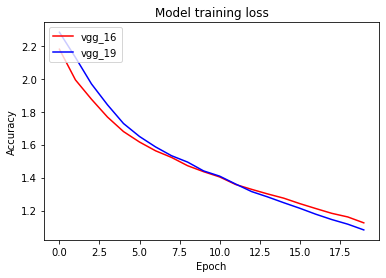

In [51]:
import matplotlib.pyplot as plt

plt.plot(history_16.history['loss'], 'r')
plt.plot(history_19.history['loss'], 'b')
plt.title('Model training loss')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['vgg_16', 'vgg_19'], loc='upper left')
plt.show()

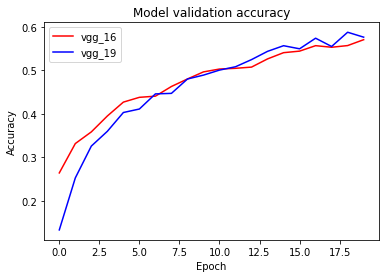

In [52]:
plt.plot(history_16.history['val_accuracy'], 'r')
plt.plot(history_19.history['val_accuracy'], 'b')
plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['vgg_16', 'vgg_19'], loc='upper left')
plt.show()

In [54]:
!pip install git+https://github.com/qubvel/classification_models.git

  Cloning https://github.com/qubvel/classification_models.git to /tmp/pip-req-build-n6x_jzm8
  Running command git clone -q https://github.com/qubvel/classification_models.git /tmp/pip-req-build-n6x_jzm8
  Running command git submodule update --init --recursive -q
     |████████████████████████████████| 51kB 3.2MB/s 
  Created wheel for image-classifiers: filename=image_classifiers-1.0.0-cp37-none-any.whl size=20049 sha256=4a45479faeee23c76d8ddef0079ce8c01342e7befcbcd7e3c9832d58b533d9ac
  Stored in directory: /tmp/pip-ephem-wheel-cache-fwjryqp_/wheels/de/2b/fd/29a6d33edb8c28bc7d94e95ea1d39c9a218ac500a3cfb1b197
Successfully built image-classifiers


In [67]:
# for keras
# from classification_models.keras import Classifiers

# for tensorflow.keras
from classification_models.tfkeras import Classifiers

ResNet34, preprocess_input = Classifiers.get('resnet34')
ResNet34((32, 32, 3), weights='imagenet').summary()

Model: "model_12"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
data (InputLayer)               [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
bn_data (BatchNormalization)    (None, 32, 32, 3)    9           data[0][0]                       
__________________________________________________________________________________________________
zero_padding2d_138 (ZeroPadding (None, 38, 38, 3)    0           bn_data[0][0]                    
__________________________________________________________________________________________________
conv0 (Conv2D)                  (None, 16, 16, 64)   9408        zero_padding2d_138[0][0]         
___________________________________________________________________________________________

In [65]:
# for keras
# from classification_models.keras import Classifiers

# for tensorflow.keras
from classification_models.tfkeras import Classifiers

ResNet50, preprocess_input = Classifiers.get('resnet50')
model = ResNet50((32, 32, 3), weights='imagenet')
model.summary()

102793216/102793104 [==============================] - 2s 0us/step
Model: "model_10"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
data (InputLayer)               [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
bn_data (BatchNormalization)    (None, 32, 32, 3)    9           data[0][0]                       
__________________________________________________________________________________________________
zero_padding2d_86 (ZeroPadding2 (None, 38, 38, 3)    0           bn_data[0][0]                    
__________________________________________________________________________________________________
conv0 (Conv2D)                  (None, 16, 16, 64)   9408        zero_padding2d_86[0][0]          
________________________

In [ ]:
resnet34
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
==================================================================================================
data (InputLayer)               [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
bn_data (BatchNormalization)    (None, 32, 32, 3)    9           data[0][0]                       
__________________________________________________________________________________________________
zero_padding2d_138 (ZeroPadding (None, 38, 38, 3)    0           bn_data[0][0]                    
__________________________________________________________________________________________________
conv0 (Conv2D)                  (None, 16, 16, 64)   9408        zero_padding2d_138[0][0]         
__________________________________________________________________________________________________
bn0 (BatchNormalization)        (None, 16, 16, 64)   256         conv0[0][0]                      
__________________________________________________________________________________________________
relu0 (Activation)              (None, 16, 16, 64)   0           bn0[0][0]                        
__________________________________________________________________________________________________
zero_padding2d_139 (ZeroPadding (None, 18, 18, 64)   0           relu0[0][0]                      
__________________________________________________________________________________________________
pooling0 (MaxPooling2D)         (None, 8, 8, 64)     0           zero_padding2d_139[0][0]         
__________________________________________________________________________________________________
stage1_unit1_bn1 (BatchNormaliz (None, 8, 8, 64)     256         pooling0[0][0]                   
__________________________________________________________________________________________________
stage1_unit1_relu1 (Activation) (None, 8, 8, 64)     0           stage1_unit1_bn1[0][0]           
__________________________________________________________________________________________________
zero_padding2d_140 (ZeroPadding (None, 10, 10, 64)   0           stage1_unit1_relu1[0][0]         
__________________________________________________________________________________________________
stage1_unit1_conv1 (Conv2D)     (None, 8, 8, 64)     36864       zero_padding2d_140[0][0]         
__________________________________________________________________________________________________
stage1_unit1_bn2 (BatchNormaliz (None, 8, 8, 64)     256         stage1_unit1_conv1[0][0]         
__________________________________________________________________________________________________
stage1_unit1_relu2 (Activation) (None, 8, 8, 64)     0           stage1_unit1_bn2[0][0]           
__________________________________________________________________________________________________
zero_padding2d_141 (ZeroPadding (None, 10, 10, 64)   0           stage1_unit1_relu2[0][0]         
__________________________________________________________________________________________________
stage1_unit1_conv2 (Conv2D)     (None, 8, 8, 64)     36864       zero_padding2d_141[0][0]         
__________________________________________________________________________________________________
stage1_unit1_sc (Conv2D)        (None, 8, 8, 64)     4096        stage1_unit1_relu1[0][0]         
__________________________________________________________________________________________________
add_72 (Add)                    (None, 8, 8, 64)     0           stage1_unit1_conv2[0][0]         
                                                                 stage1_unit1_sc[0][0]            
__________________________________________________________________________________________________
stage1_unit2_bn1 (BatchNormaliz (None, 8, 8, 64)     256         add_72[0][0]                     
__________________________________________________________________________________________________
stage1_unit2_relu1 (Activation) (None, 8, 8, 64)     0           stage1_unit2_bn1[0][0]           
__________________________________________________________________________________________________
zero_padding2d_142 (ZeroPadding (None, 10, 10, 64)   0           stage1_unit2_relu1[0][0]         
__________________________________________________________________________________________________
stage1_unit2_conv1 (Conv2D)     (None, 8, 8, 64)     36864       zero_padding2d_142[0][0]         
__________________________________________________________________________________________________
stage1_unit2_bn2 (BatchNormaliz (None, 8, 8, 64)     256         stage1_unit2_conv1[0][0]         
__________________________________________________________________________________________________
stage1_unit2_relu2 (Activation) (None, 8, 8, 64)     0           stage1_unit2_bn2[0][0]           
__________________________________________________________________________________________________
zero_padding2d_143 (ZeroPadding (None, 10, 10, 64)   0           stage1_unit2_relu2[0][0]         
__________________________________________________________________________________________________
stage1_unit2_conv2 (Conv2D)     (None, 8, 8, 64)     36864       zero_padding2d_143[0][0]         
__________________________________________________________________________________________________
add_73 (Add)                    (None, 8, 8, 64)     0           stage1_unit2_conv2[0][0]         
                                                                 add_72[0][0]                     
__________________________________________________________________________________________________
stage1_unit3_bn1 (BatchNormaliz (None, 8, 8, 64)     256         add_73[0][0]                     
__________________________________________________________________________________________________
stage1_unit3_relu1 (Activation) (None, 8, 8, 64)     0           stage1_unit3_bn1[0][0]           
__________________________________________________________________________________________________
zero_padding2d_144 (ZeroPadding (None, 10, 10, 64)   0           stage1_unit3_relu1[0][0]         
__________________________________________________________________________________________________
stage1_unit3_conv1 (Conv2D)     (None, 8, 8, 64)     36864       zero_padding2d_144[0][0]         
__________________________________________________________________________________________________
stage1_unit3_bn2 (BatchNormaliz (None, 8, 8, 64)     256         stage1_unit3_conv1[0][0]         
__________________________________________________________________________________________________
stage1_unit3_relu2 (Activation) (None, 8, 8, 64)     0           stage1_unit3_bn2[0][0]           
__________________________________________________________________________________________________
zero_padding2d_145 (ZeroPadding (None, 10, 10, 64)   0           stage1_unit3_relu2[0][0]         
__________________________________________________________________________________________________
stage1_unit3_conv2 (Conv2D)     (None, 8, 8, 64)     36864       zero_padding2d_145[0][0]         
__________________________________________________________________________________________________
add_74 (Add)                    (None, 8, 8, 64)     0           stage1_unit3_conv2[0][0]         
                                                                 add_73[0][0]                     
__________________________________________________________________________________________________
stage2_unit1_bn1 (BatchNormaliz (None, 8, 8, 64)     256         add_74[0][0]                     
__________________________________________________________________________________________________
stage2_unit1_relu1 (Activation) (None, 8, 8, 64)     0           stage2_unit1_bn1[0][0]           
__________________________________________________________________________________________________
zero_padding2d_146 (ZeroPadding (None, 10, 10, 64)   0           stage2_unit1_relu1[0][0]         
__________________________________________________________________________________________________
stage2_unit1_conv1 (Conv2D)     (None, 4, 4, 128)    73728       zero_padding2d_146[0][0]         
__________________________________________________________________________________________________
stage2_unit1_bn2 (BatchNormaliz (None, 4, 4, 128)    512         stage2_unit1_conv1[0][0]         
__________________________________________________________________________________________________
stage2_unit1_relu2 (Activation) (None, 4, 4, 128)    0           stage2_unit1_bn2[0][0]           
__________________________________________________________________________________________________
zero_padding2d_147 (ZeroPadding (None, 6, 6, 128)    0           stage2_unit1_relu2[0][0]         
__________________________________________________________________________________________________
stage2_unit1_conv2 (Conv2D)     (None, 4, 4, 128)    147456      zero_padding2d_147[0][0]         
__________________________________________________________________________________________________
stage2_unit1_sc (Conv2D)        (None, 4, 4, 128)    8192        stage2_unit1_relu1[0][0]         
__________________________________________________________________________________________________
add_75 (Add)                    (None, 4, 4, 128)    0           stage2_unit1_conv2[0][0]         
                                                                 stage2_unit1_sc[0][0]            
__________________________________________________________________________________________________
stage2_unit2_bn1 (BatchNormaliz (None, 4, 4, 128)    512         add_75[0][0]                     
__________________________________________________________________________________________________
stage2_unit2_relu1 (Activation) (None, 4, 4, 128)    0           stage2_unit2_bn1[0][0]           
__________________________________________________________________________________________________
zero_padding2d_148 (ZeroPadding (None, 6, 6, 128)    0           stage2_unit2_relu1[0][0]         
__________________________________________________________________________________________________
stage2_unit2_conv1 (Conv2D)     (None, 4, 4, 128)    147456      zero_padding2d_148[0][0]         
__________________________________________________________________________________________________
stage2_unit2_bn2 (BatchNormaliz (None, 4, 4, 128)    512         stage2_unit2_conv1[0][0]         
__________________________________________________________________________________________________
stage2_unit2_relu2 (Activation) (None, 4, 4, 128)    0           stage2_unit2_bn2[0][0]           
__________________________________________________________________________________________________
zero_padding2d_149 (ZeroPadding (None, 6, 6, 128)    0           stage2_unit2_relu2[0][0]         
__________________________________________________________________________________________________
stage2_unit2_conv2 (Conv2D)     (None, 4, 4, 128)    147456      zero_padding2d_149[0][0]         
__________________________________________________________________________________________________
add_76 (Add)                    (None, 4, 4, 128)    0           stage2_unit2_conv2[0][0]         
                                                                 add_75[0][0]                     
__________________________________________________________________________________________________
stage2_unit3_bn1 (BatchNormaliz (None, 4, 4, 128)    512         add_76[0][0]                     
__________________________________________________________________________________________________
stage2_unit3_relu1 (Activation) (None, 4, 4, 128)    0           stage2_unit3_bn1[0][0]           
__________________________________________________________________________________________________
zero_padding2d_150 (ZeroPadding (None, 6, 6, 128)    0           stage2_unit3_relu1[0][0]         
__________________________________________________________________________________________________
stage2_unit3_conv1 (Conv2D)     (None, 4, 4, 128)    147456      zero_padding2d_150[0][0]         
__________________________________________________________________________________________________
stage2_unit3_bn2 (BatchNormaliz (None, 4, 4, 128)    512         stage2_unit3_conv1[0][0]         
__________________________________________________________________________________________________
stage2_unit3_relu2 (Activation) (None, 4, 4, 128)    0           stage2_unit3_bn2[0][0]           
__________________________________________________________________________________________________
zero_padding2d_151 (ZeroPadding (None, 6, 6, 128)    0           stage2_unit3_relu2[0][0]         
__________________________________________________________________________________________________
stage2_unit3_conv2 (Conv2D)     (None, 4, 4, 128)    147456      zero_padding2d_151[0][0]         
__________________________________________________________________________________________________
add_77 (Add)                    (None, 4, 4, 128)    0           stage2_unit3_conv2[0][0]         
                                                                 add_76[0][0]                     
__________________________________________________________________________________________________
stage2_unit4_bn1 (BatchNormaliz (None, 4, 4, 128)    512         add_77[0][0]                     
__________________________________________________________________________________________________
stage2_unit4_relu1 (Activation) (None, 4, 4, 128)    0           stage2_unit4_bn1[0][0]           
__________________________________________________________________________________________________
zero_padding2d_152 (ZeroPadding (None, 6, 6, 128)    0           stage2_unit4_relu1[0][0]         
__________________________________________________________________________________________________
stage2_unit4_conv1 (Conv2D)     (None, 4, 4, 128)    147456      zero_padding2d_152[0][0]         
__________________________________________________________________________________________________
stage2_unit4_bn2 (BatchNormaliz (None, 4, 4, 128)    512         stage2_unit4_conv1[0][0]         
__________________________________________________________________________________________________
stage2_unit4_relu2 (Activation) (None, 4, 4, 128)    0           stage2_unit4_bn2[0][0]           
__________________________________________________________________________________________________
zero_padding2d_153 (ZeroPadding (None, 6, 6, 128)    0           stage2_unit4_relu2[0][0]         
__________________________________________________________________________________________________
stage2_unit4_conv2 (Conv2D)     (None, 4, 4, 128)    147456      zero_padding2d_153[0][0]         
__________________________________________________________________________________________________
add_78 (Add)                    (None, 4, 4, 128)    0           stage2_unit4_conv2[0][0]         
                                                                 add_77[0][0]                     
__________________________________________________________________________________________________
stage3_unit1_bn1 (BatchNormaliz (None, 4, 4, 128)    512         add_78[0][0]                     
__________________________________________________________________________________________________
stage3_unit1_relu1 (Activation) (None, 4, 4, 128)    0           stage3_unit1_bn1[0][0]           
__________________________________________________________________________________________________
zero_padding2d_154 (ZeroPadding (None, 6, 6, 128)    0           stage3_unit1_relu1[0][0]         
__________________________________________________________________________________________________
stage3_unit1_conv1 (Conv2D)     (None, 2, 2, 256)    294912      zero_padding2d_154[0][0]         
__________________________________________________________________________________________________
stage3_unit1_bn2 (BatchNormaliz (None, 2, 2, 256)    1024        stage3_unit1_conv1[0][0]         
__________________________________________________________________________________________________
stage3_unit1_relu2 (Activation) (None, 2, 2, 256)    0           stage3_unit1_bn2[0][0]           
__________________________________________________________________________________________________
zero_padding2d_155 (ZeroPadding (None, 4, 4, 256)    0           stage3_unit1_relu2[0][0]         
__________________________________________________________________________________________________
stage3_unit1_conv2 (Conv2D)     (None, 2, 2, 256)    589824      zero_padding2d_155[0][0]         
__________________________________________________________________________________________________
stage3_unit1_sc (Conv2D)        (None, 2, 2, 256)    32768       stage3_unit1_relu1[0][0]         
__________________________________________________________________________________________________
add_79 (Add)                    (None, 2, 2, 256)    0           stage3_unit1_conv2[0][0]         
                                                                 stage3_unit1_sc[0][0]            
__________________________________________________________________________________________________
stage3_unit2_bn1 (BatchNormaliz (None, 2, 2, 256)    1024        add_79[0][0]                     
__________________________________________________________________________________________________
stage3_unit2_relu1 (Activation) (None, 2, 2, 256)    0           stage3_unit2_bn1[0][0]           
__________________________________________________________________________________________________
zero_padding2d_156 (ZeroPadding (None, 4, 4, 256)    0           stage3_unit2_relu1[0][0]         
__________________________________________________________________________________________________
stage3_unit2_conv1 (Conv2D)     (None, 2, 2, 256)    589824      zero_padding2d_156[0][0]         
__________________________________________________________________________________________________
stage3_unit2_bn2 (BatchNormaliz (None, 2, 2, 256)    1024        stage3_unit2_conv1[0][0]         
__________________________________________________________________________________________________
stage3_unit2_relu2 (Activation) (None, 2, 2, 256)    0           stage3_unit2_bn2[0][0]           
__________________________________________________________________________________________________
zero_padding2d_157 (ZeroPadding (None, 4, 4, 256)    0           stage3_unit2_relu2[0][0]         
__________________________________________________________________________________________________
stage3_unit2_conv2 (Conv2D)     (None, 2, 2, 256)    589824      zero_padding2d_157[0][0]         
__________________________________________________________________________________________________
add_80 (Add)                    (None, 2, 2, 256)    0           stage3_unit2_conv2[0][0]         
                                                                 add_79[0][0]                     
__________________________________________________________________________________________________
stage3_unit3_bn1 (BatchNormaliz (None, 2, 2, 256)    1024        add_80[0][0]                     
__________________________________________________________________________________________________
stage3_unit3_relu1 (Activation) (None, 2, 2, 256)    0           stage3_unit3_bn1[0][0]           
__________________________________________________________________________________________________
zero_padding2d_158 (ZeroPadding (None, 4, 4, 256)    0           stage3_unit3_relu1[0][0]         
__________________________________________________________________________________________________
stage3_unit3_conv1 (Conv2D)     (None, 2, 2, 256)    589824      zero_padding2d_158[0][0]         
__________________________________________________________________________________________________
stage3_unit3_bn2 (BatchNormaliz (None, 2, 2, 256)    1024        stage3_unit3_conv1[0][0]         
__________________________________________________________________________________________________
stage3_unit3_relu2 (Activation) (None, 2, 2, 256)    0           stage3_unit3_bn2[0][0]           
__________________________________________________________________________________________________
zero_padding2d_159 (ZeroPadding (None, 4, 4, 256)    0           stage3_unit3_relu2[0][0]         
__________________________________________________________________________________________________
stage3_unit3_conv2 (Conv2D)     (None, 2, 2, 256)    589824      zero_padding2d_159[0][0]         
__________________________________________________________________________________________________
add_81 (Add)                    (None, 2, 2, 256)    0           stage3_unit3_conv2[0][0]         
                                                                 add_80[0][0]                     
__________________________________________________________________________________________________
stage3_unit4_bn1 (BatchNormaliz (None, 2, 2, 256)    1024        add_81[0][0]                     
__________________________________________________________________________________________________
stage3_unit4_relu1 (Activation) (None, 2, 2, 256)    0           stage3_unit4_bn1[0][0]           
__________________________________________________________________________________________________
zero_padding2d_160 (ZeroPadding (None, 4, 4, 256)    0           stage3_unit4_relu1[0][0]         
__________________________________________________________________________________________________
stage3_unit4_conv1 (Conv2D)     (None, 2, 2, 256)    589824      zero_padding2d_160[0][0]         
__________________________________________________________________________________________________
stage3_unit4_bn2 (BatchNormaliz (None, 2, 2, 256)    1024        stage3_unit4_conv1[0][0]         
__________________________________________________________________________________________________
stage3_unit4_relu2 (Activation) (None, 2, 2, 256)    0           stage3_unit4_bn2[0][0]           
__________________________________________________________________________________________________
zero_padding2d_161 (ZeroPadding (None, 4, 4, 256)    0           stage3_unit4_relu2[0][0]         
__________________________________________________________________________________________________
stage3_unit4_conv2 (Conv2D)     (None, 2, 2, 256)    589824      zero_padding2d_161[0][0]         
__________________________________________________________________________________________________
add_82 (Add)                    (None, 2, 2, 256)    0           stage3_unit4_conv2[0][0]         
                                                                 add_81[0][0]                     
__________________________________________________________________________________________________
stage3_unit5_bn1 (BatchNormaliz (None, 2, 2, 256)    1024        add_82[0][0]                     
__________________________________________________________________________________________________
stage3_unit5_relu1 (Activation) (None, 2, 2, 256)    0           stage3_unit5_bn1[0][0]           
__________________________________________________________________________________________________
zero_padding2d_162 (ZeroPadding (None, 4, 4, 256)    0           stage3_unit5_relu1[0][0]         
__________________________________________________________________________________________________
stage3_unit5_conv1 (Conv2D)     (None, 2, 2, 256)    589824      zero_padding2d_162[0][0]         
__________________________________________________________________________________________________
stage3_unit5_bn2 (BatchNormaliz (None, 2, 2, 256)    1024        stage3_unit5_conv1[0][0]         
__________________________________________________________________________________________________
stage3_unit5_relu2 (Activation) (None, 2, 2, 256)    0           stage3_unit5_bn2[0][0]           
__________________________________________________________________________________________________
zero_padding2d_163 (ZeroPadding (None, 4, 4, 256)    0           stage3_unit5_relu2[0][0]         
__________________________________________________________________________________________________
stage3_unit5_conv2 (Conv2D)     (None, 2, 2, 256)    589824      zero_padding2d_163[0][0]         
__________________________________________________________________________________________________
add_83 (Add)                    (None, 2, 2, 256)    0           stage3_unit5_conv2[0][0]         
                                                                 add_82[0][0]                     
__________________________________________________________________________________________________
stage3_unit6_bn1 (BatchNormaliz (None, 2, 2, 256)    1024        add_83[0][0]                     
__________________________________________________________________________________________________
stage3_unit6_relu1 (Activation) (None, 2, 2, 256)    0           stage3_unit6_bn1[0][0]           
__________________________________________________________________________________________________
zero_padding2d_164 (ZeroPadding (None, 4, 4, 256)    0           stage3_unit6_relu1[0][0]         
__________________________________________________________________________________________________
stage3_unit6_conv1 (Conv2D)     (None, 2, 2, 256)    589824      zero_padding2d_164[0][0]         
__________________________________________________________________________________________________
stage3_unit6_bn2 (BatchNormaliz (None, 2, 2, 256)    1024        stage3_unit6_conv1[0][0]         
__________________________________________________________________________________________________
stage3_unit6_relu2 (Activation) (None, 2, 2, 256)    0           stage3_unit6_bn2[0][0]           
__________________________________________________________________________________________________
zero_padding2d_165 (ZeroPadding (None, 4, 4, 256)    0           stage3_unit6_relu2[0][0]         
__________________________________________________________________________________________________
stage3_unit6_conv2 (Conv2D)     (None, 2, 2, 256)    589824      zero_padding2d_165[0][0]         
__________________________________________________________________________________________________
add_84 (Add)                    (None, 2, 2, 256)    0           stage3_unit6_conv2[0][0]         
                                                                 add_83[0][0]                     
__________________________________________________________________________________________________
stage4_unit1_bn1 (BatchNormaliz (None, 2, 2, 256)    1024        add_84[0][0]                     
__________________________________________________________________________________________________
stage4_unit1_relu1 (Activation) (None, 2, 2, 256)    0           stage4_unit1_bn1[0][0]           
__________________________________________________________________________________________________
zero_padding2d_166 (ZeroPadding (None, 4, 4, 256)    0           stage4_unit1_relu1[0][0]         
__________________________________________________________________________________________________
stage4_unit1_conv1 (Conv2D)     (None, 1, 1, 512)    1179648     zero_padding2d_166[0][0]         
__________________________________________________________________________________________________
stage4_unit1_bn2 (BatchNormaliz (None, 1, 1, 512)    2048        stage4_unit1_conv1[0][0]         
__________________________________________________________________________________________________
stage4_unit1_relu2 (Activation) (None, 1, 1, 512)    0           stage4_unit1_bn2[0][0]           
__________________________________________________________________________________________________
zero_padding2d_167 (ZeroPadding (None, 3, 3, 512)    0           stage4_unit1_relu2[0][0]         
__________________________________________________________________________________________________
stage4_unit1_conv2 (Conv2D)     (None, 1, 1, 512)    2359296     zero_padding2d_167[0][0]         
__________________________________________________________________________________________________
stage4_unit1_sc (Conv2D)        (None, 1, 1, 512)    131072      stage4_unit1_relu1[0][0]         
__________________________________________________________________________________________________
add_85 (Add)                    (None, 1, 1, 512)    0           stage4_unit1_conv2[0][0]         
                                                                 stage4_unit1_sc[0][0]            
__________________________________________________________________________________________________
stage4_unit2_bn1 (BatchNormaliz (None, 1, 1, 512)    2048        add_85[0][0]                     
__________________________________________________________________________________________________
stage4_unit2_relu1 (Activation) (None, 1, 1, 512)    0           stage4_unit2_bn1[0][0]           
__________________________________________________________________________________________________
zero_padding2d_168 (ZeroPadding (None, 3, 3, 512)    0           stage4_unit2_relu1[0][0]         
__________________________________________________________________________________________________
stage4_unit2_conv1 (Conv2D)     (None, 1, 1, 512)    2359296     zero_padding2d_168[0][0]         
__________________________________________________________________________________________________
stage4_unit2_bn2 (BatchNormaliz (None, 1, 1, 512)    2048        stage4_unit2_conv1[0][0]         
__________________________________________________________________________________________________
stage4_unit2_relu2 (Activation) (None, 1, 1, 512)    0           stage4_unit2_bn2[0][0]           
__________________________________________________________________________________________________
zero_padding2d_169 (ZeroPadding (None, 3, 3, 512)    0           stage4_unit2_relu2[0][0]         
__________________________________________________________________________________________________
stage4_unit2_conv2 (Conv2D)     (None, 1, 1, 512)    2359296     zero_padding2d_169[0][0]         
__________________________________________________________________________________________________
add_86 (Add)                    (None, 1, 1, 512)    0           stage4_unit2_conv2[0][0]         
                                                                 add_85[0][0]                     
__________________________________________________________________________________________________
stage4_unit3_bn1 (BatchNormaliz (None, 1, 1, 512)    2048        add_86[0][0]                     
__________________________________________________________________________________________________
stage4_unit3_relu1 (Activation) (None, 1, 1, 512)    0           stage4_unit3_bn1[0][0]           
__________________________________________________________________________________________________
zero_padding2d_170 (ZeroPadding (None, 3, 3, 512)    0           stage4_unit3_relu1[0][0]         
__________________________________________________________________________________________________
stage4_unit3_conv1 (Conv2D)     (None, 1, 1, 512)    2359296     zero_padding2d_170[0][0]         
__________________________________________________________________________________________________
stage4_unit3_bn2 (BatchNormaliz (None, 1, 1, 512)    2048        stage4_unit3_conv1[0][0]         
__________________________________________________________________________________________________
stage4_unit3_relu2 (Activation) (None, 1, 1, 512)    0           stage4_unit3_bn2[0][0]           
__________________________________________________________________________________________________
zero_padding2d_171 (ZeroPadding (None, 3, 3, 512)    0           stage4_unit3_relu2[0][0]         
__________________________________________________________________________________________________
stage4_unit3_conv2 (Conv2D)     (None, 1, 1, 512)    2359296     zero_padding2d_171[0][0]         
__________________________________________________________________________________________________
add_87 (Add)                    (None, 1, 1, 512)    0           stage4_unit3_conv2[0][0]         
                                                                 add_86[0][0]                     
__________________________________________________________________________________________________
bn1 (BatchNormalization)        (None, 1, 1, 512)    2048        add_87[0][0]                     
__________________________________________________________________________________________________
relu1 (Activation)              (None, 1, 1, 512)    0           bn1[0][0]                        
__________________________________________________________________________________________________
pool1 (GlobalAveragePooling2D)  (None, 512)          0           relu1[0][0]                      
__________________________________________________________________________________________________
fc1 (Dense)                     (None, 1000)         513000      pool1[0][0]                      
__________________________________________________________________________________________________
softmax (Activation)            (None, 1000)         0           fc1[0][0]                        
==================================================================================================
Total params: 21,815,473
Trainable params: 21,800,107
Non-trainable params: 15,366
__________________________________________________________________________________________________

In [ ]:
resnet50

Layer (type)                    Output Shape         Param #     Connected to                     
==================================================================================================
data (InputLayer)               [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
bn_data (BatchNormalization)    (None, 32, 32, 3)    9           data[0][0]                       
__________________________________________________________________________________________________
zero_padding2d_86 (ZeroPadding2 (None, 38, 38, 3)    0           bn_data[0][0]                    
__________________________________________________________________________________________________
conv0 (Conv2D)                  (None, 16, 16, 64)   9408        zero_padding2d_86[0][0]          
__________________________________________________________________________________________________
bn0 (BatchNormalization)        (None, 16, 16, 64)   256         conv0[0][0]                      
__________________________________________________________________________________________________
relu0 (Activation)              (None, 16, 16, 64)   0           bn0[0][0]                        
__________________________________________________________________________________________________
zero_padding2d_87 (ZeroPadding2 (None, 18, 18, 64)   0           relu0[0][0]                      
__________________________________________________________________________________________________
pooling0 (MaxPooling2D)         (None, 8, 8, 64)     0           zero_padding2d_87[0][0]          
__________________________________________________________________________________________________
stage1_unit1_bn1 (BatchNormaliz (None, 8, 8, 64)     256         pooling0[0][0]                   
__________________________________________________________________________________________________
stage1_unit1_relu1 (Activation) (None, 8, 8, 64)     0           stage1_unit1_bn1[0][0]           
__________________________________________________________________________________________________
stage1_unit1_conv1 (Conv2D)     (None, 8, 8, 64)     4096        stage1_unit1_relu1[0][0]         
__________________________________________________________________________________________________
stage1_unit1_bn2 (BatchNormaliz (None, 8, 8, 64)     256         stage1_unit1_conv1[0][0]         
__________________________________________________________________________________________________
stage1_unit1_relu2 (Activation) (None, 8, 8, 64)     0           stage1_unit1_bn2[0][0]           
__________________________________________________________________________________________________
zero_padding2d_88 (ZeroPadding2 (None, 10, 10, 64)   0           stage1_unit1_relu2[0][0]         
__________________________________________________________________________________________________
stage1_unit1_conv2 (Conv2D)     (None, 8, 8, 64)     36864       zero_padding2d_88[0][0]          
__________________________________________________________________________________________________
stage1_unit1_bn3 (BatchNormaliz (None, 8, 8, 64)     256         stage1_unit1_conv2[0][0]         
__________________________________________________________________________________________________
stage1_unit1_relu3 (Activation) (None, 8, 8, 64)     0           stage1_unit1_bn3[0][0]           
__________________________________________________________________________________________________
stage1_unit1_conv3 (Conv2D)     (None, 8, 8, 256)    16384       stage1_unit1_relu3[0][0]         
__________________________________________________________________________________________________
stage1_unit1_sc (Conv2D)        (None, 8, 8, 256)    16384       stage1_unit1_relu1[0][0]         
__________________________________________________________________________________________________
add_40 (Add)                    (None, 8, 8, 256)    0           stage1_unit1_conv3[0][0]         
                                                                 stage1_unit1_sc[0][0]            
__________________________________________________________________________________________________
stage1_unit2_bn1 (BatchNormaliz (None, 8, 8, 256)    1024        add_40[0][0]                     
__________________________________________________________________________________________________
stage1_unit2_relu1 (Activation) (None, 8, 8, 256)    0           stage1_unit2_bn1[0][0]           
__________________________________________________________________________________________________
stage1_unit2_conv1 (Conv2D)     (None, 8, 8, 64)     16384       stage1_unit2_relu1[0][0]         
__________________________________________________________________________________________________
stage1_unit2_bn2 (BatchNormaliz (None, 8, 8, 64)     256         stage1_unit2_conv1[0][0]         
__________________________________________________________________________________________________
stage1_unit2_relu2 (Activation) (None, 8, 8, 64)     0           stage1_unit2_bn2[0][0]           
__________________________________________________________________________________________________
zero_padding2d_89 (ZeroPadding2 (None, 10, 10, 64)   0           stage1_unit2_relu2[0][0]         
__________________________________________________________________________________________________
stage1_unit2_conv2 (Conv2D)     (None, 8, 8, 64)     36864       zero_padding2d_89[0][0]          
__________________________________________________________________________________________________
stage1_unit2_bn3 (BatchNormaliz (None, 8, 8, 64)     256         stage1_unit2_conv2[0][0]         
__________________________________________________________________________________________________
stage1_unit2_relu3 (Activation) (None, 8, 8, 64)     0           stage1_unit2_bn3[0][0]           
__________________________________________________________________________________________________
stage1_unit2_conv3 (Conv2D)     (None, 8, 8, 256)    16384       stage1_unit2_relu3[0][0]         
__________________________________________________________________________________________________
add_41 (Add)                    (None, 8, 8, 256)    0           stage1_unit2_conv3[0][0]         
                                                                 add_40[0][0]                     
__________________________________________________________________________________________________
stage1_unit3_bn1 (BatchNormaliz (None, 8, 8, 256)    1024        add_41[0][0]                     
__________________________________________________________________________________________________
stage1_unit3_relu1 (Activation) (None, 8, 8, 256)    0           stage1_unit3_bn1[0][0]           
__________________________________________________________________________________________________
stage1_unit3_conv1 (Conv2D)     (None, 8, 8, 64)     16384       stage1_unit3_relu1[0][0]         
__________________________________________________________________________________________________
stage1_unit3_bn2 (BatchNormaliz (None, 8, 8, 64)     256         stage1_unit3_conv1[0][0]         
__________________________________________________________________________________________________
stage1_unit3_relu2 (Activation) (None, 8, 8, 64)     0           stage1_unit3_bn2[0][0]           
__________________________________________________________________________________________________
zero_padding2d_90 (ZeroPadding2 (None, 10, 10, 64)   0           stage1_unit3_relu2[0][0]         
__________________________________________________________________________________________________
stage1_unit3_conv2 (Conv2D)     (None, 8, 8, 64)     36864       zero_padding2d_90[0][0]          
__________________________________________________________________________________________________
stage1_unit3_bn3 (BatchNormaliz (None, 8, 8, 64)     256         stage1_unit3_conv2[0][0]         
__________________________________________________________________________________________________
stage1_unit3_relu3 (Activation) (None, 8, 8, 64)     0           stage1_unit3_bn3[0][0]           
__________________________________________________________________________________________________
stage1_unit3_conv3 (Conv2D)     (None, 8, 8, 256)    16384       stage1_unit3_relu3[0][0]         
__________________________________________________________________________________________________
add_42 (Add)                    (None, 8, 8, 256)    0           stage1_unit3_conv3[0][0]         
                                                                 add_41[0][0]                     
__________________________________________________________________________________________________
stage2_unit1_bn1 (BatchNormaliz (None, 8, 8, 256)    1024        add_42[0][0]                     
__________________________________________________________________________________________________
stage2_unit1_relu1 (Activation) (None, 8, 8, 256)    0           stage2_unit1_bn1[0][0]           
__________________________________________________________________________________________________
stage2_unit1_conv1 (Conv2D)     (None, 8, 8, 128)    32768       stage2_unit1_relu1[0][0]         
__________________________________________________________________________________________________
stage2_unit1_bn2 (BatchNormaliz (None, 8, 8, 128)    512         stage2_unit1_conv1[0][0]         
__________________________________________________________________________________________________
stage2_unit1_relu2 (Activation) (None, 8, 8, 128)    0           stage2_unit1_bn2[0][0]           
__________________________________________________________________________________________________
zero_padding2d_91 (ZeroPadding2 (None, 10, 10, 128)  0           stage2_unit1_relu2[0][0]         
__________________________________________________________________________________________________
stage2_unit1_conv2 (Conv2D)     (None, 4, 4, 128)    147456      zero_padding2d_91[0][0]          
__________________________________________________________________________________________________
stage2_unit1_bn3 (BatchNormaliz (None, 4, 4, 128)    512         stage2_unit1_conv2[0][0]         
__________________________________________________________________________________________________
stage2_unit1_relu3 (Activation) (None, 4, 4, 128)    0           stage2_unit1_bn3[0][0]           
__________________________________________________________________________________________________
stage2_unit1_conv3 (Conv2D)     (None, 4, 4, 512)    65536       stage2_unit1_relu3[0][0]         
__________________________________________________________________________________________________
stage2_unit1_sc (Conv2D)        (None, 4, 4, 512)    131072      stage2_unit1_relu1[0][0]         
__________________________________________________________________________________________________
add_43 (Add)                    (None, 4, 4, 512)    0           stage2_unit1_conv3[0][0]         
                                                                 stage2_unit1_sc[0][0]            
__________________________________________________________________________________________________
stage2_unit2_bn1 (BatchNormaliz (None, 4, 4, 512)    2048        add_43[0][0]                     
__________________________________________________________________________________________________
stage2_unit2_relu1 (Activation) (None, 4, 4, 512)    0           stage2_unit2_bn1[0][0]           
__________________________________________________________________________________________________
stage2_unit2_conv1 (Conv2D)     (None, 4, 4, 128)    65536       stage2_unit2_relu1[0][0]         
__________________________________________________________________________________________________
stage2_unit2_bn2 (BatchNormaliz (None, 4, 4, 128)    512         stage2_unit2_conv1[0][0]         
__________________________________________________________________________________________________
stage2_unit2_relu2 (Activation) (None, 4, 4, 128)    0           stage2_unit2_bn2[0][0]           
__________________________________________________________________________________________________
zero_padding2d_92 (ZeroPadding2 (None, 6, 6, 128)    0           stage2_unit2_relu2[0][0]         
__________________________________________________________________________________________________
stage2_unit2_conv2 (Conv2D)     (None, 4, 4, 128)    147456      zero_padding2d_92[0][0]          
__________________________________________________________________________________________________
stage2_unit2_bn3 (BatchNormaliz (None, 4, 4, 128)    512         stage2_unit2_conv2[0][0]         
__________________________________________________________________________________________________
stage2_unit2_relu3 (Activation) (None, 4, 4, 128)    0           stage2_unit2_bn3[0][0]           
__________________________________________________________________________________________________
stage2_unit2_conv3 (Conv2D)     (None, 4, 4, 512)    65536       stage2_unit2_relu3[0][0]         
__________________________________________________________________________________________________
add_44 (Add)                    (None, 4, 4, 512)    0           stage2_unit2_conv3[0][0]         
                                                                 add_43[0][0]                     
__________________________________________________________________________________________________
stage2_unit3_bn1 (BatchNormaliz (None, 4, 4, 512)    2048        add_44[0][0]                     
__________________________________________________________________________________________________
stage2_unit3_relu1 (Activation) (None, 4, 4, 512)    0           stage2_unit3_bn1[0][0]           
__________________________________________________________________________________________________
stage2_unit3_conv1 (Conv2D)     (None, 4, 4, 128)    65536       stage2_unit3_relu1[0][0]         
__________________________________________________________________________________________________
stage2_unit3_bn2 (BatchNormaliz (None, 4, 4, 128)    512         stage2_unit3_conv1[0][0]         
__________________________________________________________________________________________________
stage2_unit3_relu2 (Activation) (None, 4, 4, 128)    0           stage2_unit3_bn2[0][0]           
__________________________________________________________________________________________________
zero_padding2d_93 (ZeroPadding2 (None, 6, 6, 128)    0           stage2_unit3_relu2[0][0]         
__________________________________________________________________________________________________
stage2_unit3_conv2 (Conv2D)     (None, 4, 4, 128)    147456      zero_padding2d_93[0][0]          
__________________________________________________________________________________________________
stage2_unit3_bn3 (BatchNormaliz (None, 4, 4, 128)    512         stage2_unit3_conv2[0][0]         
__________________________________________________________________________________________________
stage2_unit3_relu3 (Activation) (None, 4, 4, 128)    0           stage2_unit3_bn3[0][0]           
__________________________________________________________________________________________________
stage2_unit3_conv3 (Conv2D)     (None, 4, 4, 512)    65536       stage2_unit3_relu3[0][0]         
__________________________________________________________________________________________________
add_45 (Add)                    (None, 4, 4, 512)    0           stage2_unit3_conv3[0][0]         
                                                                 add_44[0][0]                     
__________________________________________________________________________________________________
stage2_unit4_bn1 (BatchNormaliz (None, 4, 4, 512)    2048        add_45[0][0]                     
__________________________________________________________________________________________________
stage2_unit4_relu1 (Activation) (None, 4, 4, 512)    0           stage2_unit4_bn1[0][0]           
__________________________________________________________________________________________________
stage2_unit4_conv1 (Conv2D)     (None, 4, 4, 128)    65536       stage2_unit4_relu1[0][0]         
__________________________________________________________________________________________________
stage2_unit4_bn2 (BatchNormaliz (None, 4, 4, 128)    512         stage2_unit4_conv1[0][0]         
__________________________________________________________________________________________________
stage2_unit4_relu2 (Activation) (None, 4, 4, 128)    0           stage2_unit4_bn2[0][0]           
__________________________________________________________________________________________________
zero_padding2d_94 (ZeroPadding2 (None, 6, 6, 128)    0           stage2_unit4_relu2[0][0]         
__________________________________________________________________________________________________
stage2_unit4_conv2 (Conv2D)     (None, 4, 4, 128)    147456      zero_padding2d_94[0][0]          
__________________________________________________________________________________________________
stage2_unit4_bn3 (BatchNormaliz (None, 4, 4, 128)    512         stage2_unit4_conv2[0][0]         
__________________________________________________________________________________________________
stage2_unit4_relu3 (Activation) (None, 4, 4, 128)    0           stage2_unit4_bn3[0][0]           
__________________________________________________________________________________________________
stage2_unit4_conv3 (Conv2D)     (None, 4, 4, 512)    65536       stage2_unit4_relu3[0][0]         
__________________________________________________________________________________________________
add_46 (Add)                    (None, 4, 4, 512)    0           stage2_unit4_conv3[0][0]         
                                                                 add_45[0][0]                     
__________________________________________________________________________________________________
stage3_unit1_bn1 (BatchNormaliz (None, 4, 4, 512)    2048        add_46[0][0]                     
__________________________________________________________________________________________________
stage3_unit1_relu1 (Activation) (None, 4, 4, 512)    0           stage3_unit1_bn1[0][0]           
__________________________________________________________________________________________________
stage3_unit1_conv1 (Conv2D)     (None, 4, 4, 256)    131072      stage3_unit1_relu1[0][0]         
__________________________________________________________________________________________________
stage3_unit1_bn2 (BatchNormaliz (None, 4, 4, 256)    1024        stage3_unit1_conv1[0][0]         
__________________________________________________________________________________________________
stage3_unit1_relu2 (Activation) (None, 4, 4, 256)    0           stage3_unit1_bn2[0][0]           
__________________________________________________________________________________________________
zero_padding2d_95 (ZeroPadding2 (None, 6, 6, 256)    0           stage3_unit1_relu2[0][0]         
__________________________________________________________________________________________________
stage3_unit1_conv2 (Conv2D)     (None, 2, 2, 256)    589824      zero_padding2d_95[0][0]          
__________________________________________________________________________________________________
stage3_unit1_bn3 (BatchNormaliz (None, 2, 2, 256)    1024        stage3_unit1_conv2[0][0]         
__________________________________________________________________________________________________
stage3_unit1_relu3 (Activation) (None, 2, 2, 256)    0           stage3_unit1_bn3[0][0]           
__________________________________________________________________________________________________
stage3_unit1_conv3 (Conv2D)     (None, 2, 2, 1024)   262144      stage3_unit1_relu3[0][0]         
__________________________________________________________________________________________________
stage3_unit1_sc (Conv2D)        (None, 2, 2, 1024)   524288      stage3_unit1_relu1[0][0]         
__________________________________________________________________________________________________
add_47 (Add)                    (None, 2, 2, 1024)   0           stage3_unit1_conv3[0][0]         
                                                                 stage3_unit1_sc[0][0]            
__________________________________________________________________________________________________
stage3_unit2_bn1 (BatchNormaliz (None, 2, 2, 1024)   4096        add_47[0][0]                     
__________________________________________________________________________________________________
stage3_unit2_relu1 (Activation) (None, 2, 2, 1024)   0           stage3_unit2_bn1[0][0]           
__________________________________________________________________________________________________
stage3_unit2_conv1 (Conv2D)     (None, 2, 2, 256)    262144      stage3_unit2_relu1[0][0]         
__________________________________________________________________________________________________
stage3_unit2_bn2 (BatchNormaliz (None, 2, 2, 256)    1024        stage3_unit2_conv1[0][0]         
__________________________________________________________________________________________________
stage3_unit2_relu2 (Activation) (None, 2, 2, 256)    0           stage3_unit2_bn2[0][0]           
__________________________________________________________________________________________________
zero_padding2d_96 (ZeroPadding2 (None, 4, 4, 256)    0           stage3_unit2_relu2[0][0]         
__________________________________________________________________________________________________
stage3_unit2_conv2 (Conv2D)     (None, 2, 2, 256)    589824      zero_padding2d_96[0][0]          
__________________________________________________________________________________________________
stage3_unit2_bn3 (BatchNormaliz (None, 2, 2, 256)    1024        stage3_unit2_conv2[0][0]         
__________________________________________________________________________________________________
stage3_unit2_relu3 (Activation) (None, 2, 2, 256)    0           stage3_unit2_bn3[0][0]           
__________________________________________________________________________________________________
stage3_unit2_conv3 (Conv2D)     (None, 2, 2, 1024)   262144      stage3_unit2_relu3[0][0]         
__________________________________________________________________________________________________
add_48 (Add)                    (None, 2, 2, 1024)   0           stage3_unit2_conv3[0][0]         
                                                                 add_47[0][0]                     
__________________________________________________________________________________________________
stage3_unit3_bn1 (BatchNormaliz (None, 2, 2, 1024)   4096        add_48[0][0]                     
__________________________________________________________________________________________________
stage3_unit3_relu1 (Activation) (None, 2, 2, 1024)   0           stage3_unit3_bn1[0][0]           
__________________________________________________________________________________________________
stage3_unit3_conv1 (Conv2D)     (None, 2, 2, 256)    262144      stage3_unit3_relu1[0][0]         
__________________________________________________________________________________________________
stage3_unit3_bn2 (BatchNormaliz (None, 2, 2, 256)    1024        stage3_unit3_conv1[0][0]         
__________________________________________________________________________________________________
stage3_unit3_relu2 (Activation) (None, 2, 2, 256)    0           stage3_unit3_bn2[0][0]           
__________________________________________________________________________________________________
zero_padding2d_97 (ZeroPadding2 (None, 4, 4, 256)    0           stage3_unit3_relu2[0][0]         
__________________________________________________________________________________________________
stage3_unit3_conv2 (Conv2D)     (None, 2, 2, 256)    589824      zero_padding2d_97[0][0]          
__________________________________________________________________________________________________
stage3_unit3_bn3 (BatchNormaliz (None, 2, 2, 256)    1024        stage3_unit3_conv2[0][0]         
__________________________________________________________________________________________________
stage3_unit3_relu3 (Activation) (None, 2, 2, 256)    0           stage3_unit3_bn3[0][0]           
__________________________________________________________________________________________________
stage3_unit3_conv3 (Conv2D)     (None, 2, 2, 1024)   262144      stage3_unit3_relu3[0][0]         
__________________________________________________________________________________________________
add_49 (Add)                    (None, 2, 2, 1024)   0           stage3_unit3_conv3[0][0]         
                                                                 add_48[0][0]                     
__________________________________________________________________________________________________
stage3_unit4_bn1 (BatchNormaliz (None, 2, 2, 1024)   4096        add_49[0][0]                     
__________________________________________________________________________________________________
stage3_unit4_relu1 (Activation) (None, 2, 2, 1024)   0           stage3_unit4_bn1[0][0]           
__________________________________________________________________________________________________
stage3_unit4_conv1 (Conv2D)     (None, 2, 2, 256)    262144      stage3_unit4_relu1[0][0]         
__________________________________________________________________________________________________
stage3_unit4_bn2 (BatchNormaliz (None, 2, 2, 256)    1024        stage3_unit4_conv1[0][0]         
__________________________________________________________________________________________________
stage3_unit4_relu2 (Activation) (None, 2, 2, 256)    0           stage3_unit4_bn2[0][0]           
__________________________________________________________________________________________________
zero_padding2d_98 (ZeroPadding2 (None, 4, 4, 256)    0           stage3_unit4_relu2[0][0]         
__________________________________________________________________________________________________
stage3_unit4_conv2 (Conv2D)     (None, 2, 2, 256)    589824      zero_padding2d_98[0][0]          
__________________________________________________________________________________________________
stage3_unit4_bn3 (BatchNormaliz (None, 2, 2, 256)    1024        stage3_unit4_conv2[0][0]         
__________________________________________________________________________________________________
stage3_unit4_relu3 (Activation) (None, 2, 2, 256)    0           stage3_unit4_bn3[0][0]           
__________________________________________________________________________________________________
stage3_unit4_conv3 (Conv2D)     (None, 2, 2, 1024)   262144      stage3_unit4_relu3[0][0]         
__________________________________________________________________________________________________
add_50 (Add)                    (None, 2, 2, 1024)   0           stage3_unit4_conv3[0][0]         
                                                                 add_49[0][0]                     
__________________________________________________________________________________________________
stage3_unit5_bn1 (BatchNormaliz (None, 2, 2, 1024)   4096        add_50[0][0]                     
__________________________________________________________________________________________________
stage3_unit5_relu1 (Activation) (None, 2, 2, 1024)   0           stage3_unit5_bn1[0][0]           
__________________________________________________________________________________________________
stage3_unit5_conv1 (Conv2D)     (None, 2, 2, 256)    262144      stage3_unit5_relu1[0][0]         
__________________________________________________________________________________________________
stage3_unit5_bn2 (BatchNormaliz (None, 2, 2, 256)    1024        stage3_unit5_conv1[0][0]         
__________________________________________________________________________________________________
stage3_unit5_relu2 (Activation) (None, 2, 2, 256)    0           stage3_unit5_bn2[0][0]           
__________________________________________________________________________________________________
zero_padding2d_99 (ZeroPadding2 (None, 4, 4, 256)    0           stage3_unit5_relu2[0][0]         
__________________________________________________________________________________________________
stage3_unit5_conv2 (Conv2D)     (None, 2, 2, 256)    589824      zero_padding2d_99[0][0]          
__________________________________________________________________________________________________
stage3_unit5_bn3 (BatchNormaliz (None, 2, 2, 256)    1024        stage3_unit5_conv2[0][0]         
__________________________________________________________________________________________________
stage3_unit5_relu3 (Activation) (None, 2, 2, 256)    0           stage3_unit5_bn3[0][0]           
__________________________________________________________________________________________________
stage3_unit5_conv3 (Conv2D)     (None, 2, 2, 1024)   262144      stage3_unit5_relu3[0][0]         
__________________________________________________________________________________________________
add_51 (Add)                    (None, 2, 2, 1024)   0           stage3_unit5_conv3[0][0]         
                                                                 add_50[0][0]                     
__________________________________________________________________________________________________
stage3_unit6_bn1 (BatchNormaliz (None, 2, 2, 1024)   4096        add_51[0][0]                     
__________________________________________________________________________________________________
stage3_unit6_relu1 (Activation) (None, 2, 2, 1024)   0           stage3_unit6_bn1[0][0]           
__________________________________________________________________________________________________
stage3_unit6_conv1 (Conv2D)     (None, 2, 2, 256)    262144      stage3_unit6_relu1[0][0]         
__________________________________________________________________________________________________
stage3_unit6_bn2 (BatchNormaliz (None, 2, 2, 256)    1024        stage3_unit6_conv1[0][0]         
__________________________________________________________________________________________________
stage3_unit6_relu2 (Activation) (None, 2, 2, 256)    0           stage3_unit6_bn2[0][0]           
__________________________________________________________________________________________________
zero_padding2d_100 (ZeroPadding (None, 4, 4, 256)    0           stage3_unit6_relu2[0][0]         
__________________________________________________________________________________________________
stage3_unit6_conv2 (Conv2D)     (None, 2, 2, 256)    589824      zero_padding2d_100[0][0]         
__________________________________________________________________________________________________
stage3_unit6_bn3 (BatchNormaliz (None, 2, 2, 256)    1024        stage3_unit6_conv2[0][0]         
__________________________________________________________________________________________________
stage3_unit6_relu3 (Activation) (None, 2, 2, 256)    0           stage3_unit6_bn3[0][0]           
__________________________________________________________________________________________________
stage3_unit6_conv3 (Conv2D)     (None, 2, 2, 1024)   262144      stage3_unit6_relu3[0][0]         
__________________________________________________________________________________________________
add_52 (Add)                    (None, 2, 2, 1024)   0           stage3_unit6_conv3[0][0]         
                                                                 add_51[0][0]                     
__________________________________________________________________________________________________
stage4_unit1_bn1 (BatchNormaliz (None, 2, 2, 1024)   4096        add_52[0][0]                     
__________________________________________________________________________________________________
stage4_unit1_relu1 (Activation) (None, 2, 2, 1024)   0           stage4_unit1_bn1[0][0]           
__________________________________________________________________________________________________
stage4_unit1_conv1 (Conv2D)     (None, 2, 2, 512)    524288      stage4_unit1_relu1[0][0]         
__________________________________________________________________________________________________
stage4_unit1_bn2 (BatchNormaliz (None, 2, 2, 512)    2048        stage4_unit1_conv1[0][0]         
__________________________________________________________________________________________________
stage4_unit1_relu2 (Activation) (None, 2, 2, 512)    0           stage4_unit1_bn2[0][0]           
__________________________________________________________________________________________________
zero_padding2d_101 (ZeroPadding (None, 4, 4, 512)    0           stage4_unit1_relu2[0][0]         
__________________________________________________________________________________________________
stage4_unit1_conv2 (Conv2D)     (None, 1, 1, 512)    2359296     zero_padding2d_101[0][0]         
__________________________________________________________________________________________________
stage4_unit1_bn3 (BatchNormaliz (None, 1, 1, 512)    2048        stage4_unit1_conv2[0][0]         
__________________________________________________________________________________________________
stage4_unit1_relu3 (Activation) (None, 1, 1, 512)    0           stage4_unit1_bn3[0][0]           
__________________________________________________________________________________________________
stage4_unit1_conv3 (Conv2D)     (None, 1, 1, 2048)   1048576     stage4_unit1_relu3[0][0]         
__________________________________________________________________________________________________
stage4_unit1_sc (Conv2D)        (None, 1, 1, 2048)   2097152     stage4_unit1_relu1[0][0]         
__________________________________________________________________________________________________
add_53 (Add)                    (None, 1, 1, 2048)   0           stage4_unit1_conv3[0][0]         
                                                                 stage4_unit1_sc[0][0]            
__________________________________________________________________________________________________
stage4_unit2_bn1 (BatchNormaliz (None, 1, 1, 2048)   8192        add_53[0][0]                     
__________________________________________________________________________________________________
stage4_unit2_relu1 (Activation) (None, 1, 1, 2048)   0           stage4_unit2_bn1[0][0]           
__________________________________________________________________________________________________
stage4_unit2_conv1 (Conv2D)     (None, 1, 1, 512)    1048576     stage4_unit2_relu1[0][0]         
__________________________________________________________________________________________________
stage4_unit2_bn2 (BatchNormaliz (None, 1, 1, 512)    2048        stage4_unit2_conv1[0][0]         
__________________________________________________________________________________________________
stage4_unit2_relu2 (Activation) (None, 1, 1, 512)    0           stage4_unit2_bn2[0][0]           
__________________________________________________________________________________________________
zero_padding2d_102 (ZeroPadding (None, 3, 3, 512)    0           stage4_unit2_relu2[0][0]         
__________________________________________________________________________________________________
stage4_unit2_conv2 (Conv2D)     (None, 1, 1, 512)    2359296     zero_padding2d_102[0][0]         
__________________________________________________________________________________________________
stage4_unit2_bn3 (BatchNormaliz (None, 1, 1, 512)    2048        stage4_unit2_conv2[0][0]         
__________________________________________________________________________________________________
stage4_unit2_relu3 (Activation) (None, 1, 1, 512)    0           stage4_unit2_bn3[0][0]           
__________________________________________________________________________________________________
stage4_unit2_conv3 (Conv2D)     (None, 1, 1, 2048)   1048576     stage4_unit2_relu3[0][0]         
__________________________________________________________________________________________________
add_54 (Add)                    (None, 1, 1, 2048)   0           stage4_unit2_conv3[0][0]         
                                                                 add_53[0][0]                     
__________________________________________________________________________________________________
stage4_unit3_bn1 (BatchNormaliz (None, 1, 1, 2048)   8192        add_54[0][0]                     
__________________________________________________________________________________________________
stage4_unit3_relu1 (Activation) (None, 1, 1, 2048)   0           stage4_unit3_bn1[0][0]           
__________________________________________________________________________________________________
stage4_unit3_conv1 (Conv2D)     (None, 1, 1, 512)    1048576     stage4_unit3_relu1[0][0]         
__________________________________________________________________________________________________
stage4_unit3_bn2 (BatchNormaliz (None, 1, 1, 512)    2048        stage4_unit3_conv1[0][0]         
__________________________________________________________________________________________________
stage4_unit3_relu2 (Activation) (None, 1, 1, 512)    0           stage4_unit3_bn2[0][0]           
__________________________________________________________________________________________________
zero_padding2d_103 (ZeroPadding (None, 3, 3, 512)    0           stage4_unit3_relu2[0][0]         
__________________________________________________________________________________________________
stage4_unit3_conv2 (Conv2D)     (None, 1, 1, 512)    2359296     zero_padding2d_103[0][0]         
__________________________________________________________________________________________________
stage4_unit3_bn3 (BatchNormaliz (None, 1, 1, 512)    2048        stage4_unit3_conv2[0][0]         
__________________________________________________________________________________________________
stage4_unit3_relu3 (Activation) (None, 1, 1, 512)    0           stage4_unit3_bn3[0][0]           
__________________________________________________________________________________________________
stage4_unit3_conv3 (Conv2D)     (None, 1, 1, 2048)   1048576     stage4_unit3_relu3[0][0]         
__________________________________________________________________________________________________
add_55 (Add)                    (None, 1, 1, 2048)   0           stage4_unit3_conv3[0][0]         
                                                                 add_54[0][0]                     
__________________________________________________________________________________________________
bn1 (BatchNormalization)        (None, 1, 1, 2048)   8192        add_55[0][0]                     
__________________________________________________________________________________________________
relu1 (Activation)              (None, 1, 1, 2048)   0           bn1[0][0]                        
__________________________________________________________________________________________________
pool1 (GlobalAveragePooling2D)  (None, 2048)         0           relu1[0][0]                      
__________________________________________________________________________________________________
fc1 (Dense)                     (None, 1000)         2049000     pool1[0][0]                      
__________________________________________________________________________________________________
softmax (Activation)            (None, 1000)         0           fc1[0][0]                        
==================================================================================================
Total params: 25,595,057
Trainable params: 25,549,483
Non-trainable params: 45,574
__________________________________________________________________________________________________